In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from itertools import product
from functools import reduce

## Data preparation

In [3]:
# define labels
MUST_HAVE_LABELS = ("endemic", "non_case")
DATA_LABELS = ("one", "two", "three") + MUST_HAVE_LABELS

In [4]:
# define coordinate system with two axes x1 and x2
df_coordinates = pd.concat(
    [
        pd.DataFrame(columns=["x1", "x2"], data=product(range(5), range(5))),
        pd.DataFrame(columns=DATA_LABELS),
    ]
)

In [5]:
# read in data
one = [0] * 5 + [0, 1, 1, 0, 0] + [0, 0, 1, 0, 0] + [0] * 10
two = (
    [
        0,
        0,
        1,
        1,
        1,
    ]
    + [0] * 10
    + [0, 0, 0, 1, 0]
    + [0] * 5
)
three = [0] * 15 + [0, 0, 0, 1, 2] + [0] * 5
endemic = (
    [0] * 5 + [1, 0, 0, 0, 0] + [0, 1, 0, 0, 0] + [4, 0, 0, 0, 1] + [2, 0, 0, 0, 1]
)

df_cases = df_coordinates.assign(one=one, two=two, three=three, endemic=endemic)

In [6]:
df_cases.head()

,x1,x2,one,two,three,endemic,non_case
0,0.0,0.0,0,0,0,0,NaN
1,0.0,1.0,0,0,0,0,NaN
2,0.0,2.0,0,1,0,0,NaN
3,0.0,3.0,0,1,0,0,NaN
4,0.0,4.0,0,1,0,0,NaN


In [7]:
# pad dummy-non-cases
is_non_case = df_cases.loc[:, list(DATA_LABELS)].sum(axis=1) == 0
df_padded = df_cases.assign(non_case=np.where(is_non_case, 1, 0))

In [8]:
df_padded.head()

,x1,x2,one,two,three,endemic,non_case
0,0.0,0.0,0,0,0,0,1
1,0.0,1.0,0,0,0,0,1
2,0.0,2.0,0,1,0,0,0
3,0.0,3.0,0,1,0,0,0
4,0.0,4.0,0,1,0,0,0


## Signal creation

In [9]:
def run_algo_A(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame(
        {
            "x1": [1, 1, 2, 2, 3, 4],
            "x2": [1, 2, 1, 2, 0, 0],
            "w_A": [1, 1, 1, 1, 0.5, 0.5],
        }
    )
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)


def run_algo_B(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame(
        {
            "x1": [2, 2, 2, 3, 3, 3, 4, 4, 4],
            "x2": [2, 3, 4, 2, 3, 4, 2, 3, 4],
            "w_B": [0.5] * 9,
        }
    )
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)


def run_algo_C(df_coordinates):
    assert len(df_coordinates) == 25
    signale = pd.DataFrame({"x1": [0], "x2": [4], "w_C": [1]})
    signale = df_coordinates.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)

In [10]:
# create signals
signal_A = run_algo_A(df_coordinates)
signal_B = run_algo_B(df_coordinates)
signal_C = run_algo_C(df_coordinates)

signals_without_endemic_non_case = reduce(
    lambda l, r: pd.merge(l, r, on=["x1", "x2"]),
    [signal_A, signal_B, signal_C, df_padded],
)

signals_without_endemic_non_case.head()

,x1,x2,w_A,w_B,w_C,one,two,three,endemic,non_case
0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
1,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1
2,0.0,2.0,0.0,0.0,0.0,0,1,0,0,0
3,0.0,3.0,0.0,0.0,0.0,0,1,0,0,0
4,0.0,4.0,0.0,0.0,1.0,0,1,0,0,0


In [11]:
assert (
    signals_without_endemic_non_case.query("non_case==1")
    .loc[:, ["one", "two", "three", "endemic"]]
    .sum()
    .sum()
    == 0
)

assert not any(
    (signals_without_endemic_non_case.endemic > 0)
    & (signals_without_endemic_non_case.non_case > 0)
)

### Calculate signal for endemic and non-case when not given by algo

In [12]:
def add_endemic_non_case_signals(without_endemic_non_case, aggregation_func):
    """
    Calculates signals for endemic and non cases.

    Input DataFrame must indicate signal columns with 'w_' in their name.
    """
    signal_columns = [c for c in signals_without_endemic_non_case.columns if "w_" in c]
    signal_df = without_endemic_non_case.copy()

    for signal in signal_columns:
        signal_df.loc[:, signal + "_endemic"] = (1 - signal_df.loc[:, signal]) * (
            signal_df["non_case"] == 0
        )
        signal_df.loc[:, signal + "_non_case"] = (1 - signal_df.loc[:, signal]) * (
            signal_df["non_case"] != 0
        )

    non_case_signals = signal_df.columns[
        signal_df.columns.str.contains(r"w_._non_case")
    ]
    endemic_signals = signal_df.columns[signal_df.columns.str.contains(r"w_._endemic")]

    signal_df.loc[:, "w_non_case"] = signal_df[non_case_signals].agg(
        aggregation_func, axis=1
    )
    signal_df.loc[:, "w_endemic"] = signal_df[endemic_signals].agg(
        aggregation_func, axis=1
    )
    return signal_df

In [13]:
def transform_for_heatmap(array):
    return array.reshape((5, -1)).T


def plot_heatmap(array, title):
    transformed_array = transform_for_heatmap(array)
    ax = sns.heatmap(
        transformed_array, linewidth=2, cmap="RdPu", cbar=False, annot=True
    )
    ax.add_patch(Rectangle((1, 1), 2, 2, fill=False, edgecolor="blue", lw=3))
    ax.add_patch(Rectangle((3, 0), 2, 1, fill=False, edgecolor="blue", alpha=0.6, lw=3))
    ax.add_patch(
        Rectangle((2, 2), 3, 3, fill=False, edgecolor="orange", alpha=0.6, lw=3)
    )
    ax.add_patch(Rectangle((0, 4), 1, 1, fill=False, edgecolor="green", lw=3))
    ax.set_title(title)
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 5)
    return ax

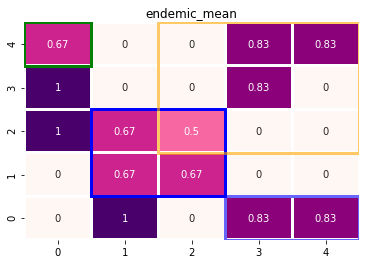

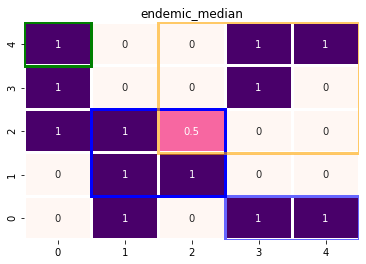

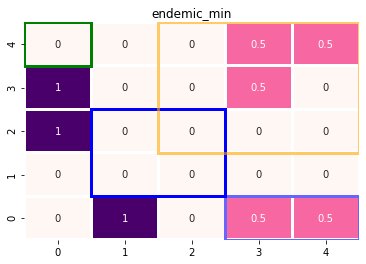

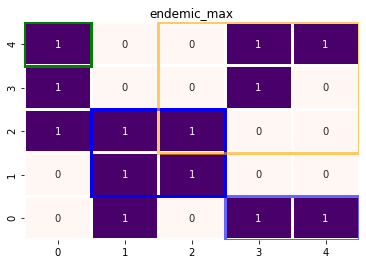

In [14]:
plot_heatmap(
    add_endemic_non_case_signals(
        signals_without_endemic_non_case, "mean"
    ).w_endemic.values,
    "endemic_mean",
)
plt.show()
plot_heatmap(
    add_endemic_non_case_signals(
        signals_without_endemic_non_case, "median"
    ).w_endemic.values,
    "endemic_median",
)
plt.show()
plot_heatmap(
    add_endemic_non_case_signals(
        signals_without_endemic_non_case, "min"
    ).w_endemic.values,
    "endemic_min",
)
plt.show()
plot_heatmap(
    add_endemic_non_case_signals(
        signals_without_endemic_non_case, "max"
    ).w_endemic.values,
    "endemic_max",
)
plt.show()

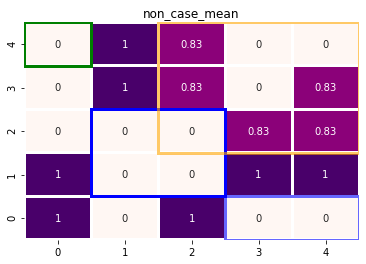

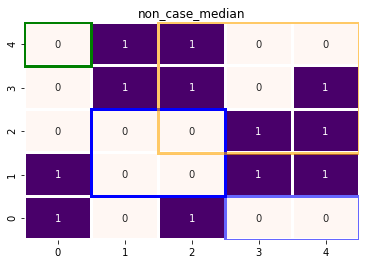

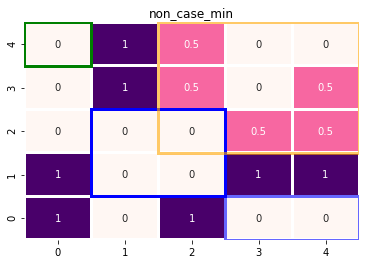

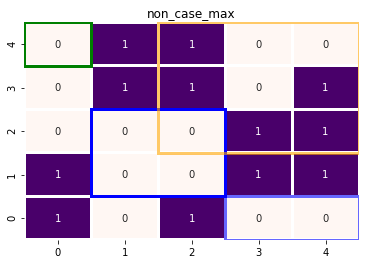

In [15]:
plot_heatmap(
    add_endemic_non_case_signals(
        signals_without_endemic_non_case, "mean"
    ).w_non_case.values,
    "non_case_mean",
)
plt.show()
plot_heatmap(
    add_endemic_non_case_signals(
        signals_without_endemic_non_case, "median"
    ).w_non_case.values,
    "non_case_median",
)
plt.show()
plot_heatmap(
    add_endemic_non_case_signals(
        signals_without_endemic_non_case, "min"
    ).w_non_case.values,
    "non_case_min",
)
plt.show()
plot_heatmap(
    add_endemic_non_case_signals(
        signals_without_endemic_non_case, "max"
    ).w_non_case.values,
    "non_case_max",
)
plt.show()

## Score calculation (regression)

In [16]:
def p_di_given_x(df_padded):
    """Calculate disease probability per cell, p(d_i| x)"""
    disease_proba_df = df_padded.copy()
    disease_proba_df.loc[:, DATA_LABELS] = disease_proba_df.loc[:, DATA_LABELS].div(
        disease_proba_df.loc[:, DATA_LABELS].sum(axis=1), axis=0
    )
    return disease_proba_df.melt(
        id_vars=["x1", "x2"], var_name="d_i", value_name="p(d_i)"
    )

In [17]:
df_di_given_x = p_di_given_x(df_padded)
df_di_given_x.tail()

,x1,x2,d_i,p(d_i)
120,4.0,0.0,non_case,0.0
121,4.0,1.0,non_case,1.0
122,4.0,2.0,non_case,1.0
123,4.0,3.0,non_case,1.0
124,4.0,4.0,non_case,0.0


In [19]:
def p_hat_sj_given_x(signals_with_endemic_non_case):
    """p^ (s_j|x) = w(s, x) / sum_s (w(s,x))"""
    df_prior_signal = signals_with_endemic_non_case.copy()
    # todo: find flexible solution
    signal_columns = ["w_A", "w_B", "w_C", "w_non_case", "w_endemic"]
    prior_columns = ["p_A", "p_B", "p_C", "p_non_case", "p_endemic"]
    sj_given_x = (
        df_prior_signal.loc[:, signal_columns]
        .div(
            df_prior_signal.loc[:, signal_columns].sum(axis=1),
            axis=0,
        )
        .values
    )

    df_prior_signal.loc[:, prior_columns] = sj_given_x

    signals_long = df_prior_signal.melt(
        id_vars=["x1", "x2"],
        value_vars=prior_columns,
        var_name="s_j_given_x",
        value_name="prior",
    ).assign(s_j=lambda x: x["s_j_given_x"].str.replace("p_", ""))
    return signals_long

In [20]:
signals_with_endemic_non_case = add_endemic_non_case_signals(
    signals_without_endemic_non_case, "mean"
)
df_sj_given_x = p_hat_sj_given_x(signals_with_endemic_non_case)

In [21]:
df_sj_given_x.head()

,x1,x2,s_j_given_x,prior,s_j
0,0.0,0.0,p_A,0.0,A
1,0.0,1.0,p_A,0.0,A
2,0.0,2.0,p_A,0.0,A
3,0.0,3.0,p_A,0.0,A
4,0.0,4.0,p_A,0.0,A


In [24]:
def p_hat_di_given_sj_x():
    """Calculates p^(d_i | s_j, x) which is algo based."""
    signal_per_diseases = list(
        product(
            product(range(5), range(5)),
            product(
                ["one", "two", "three", "endemic", "non_case"],
                ["A", "B", "C", "endemic", "non_case"],
            ),
        )
    )
    df = pd.DataFrame(
        [tuple_[0] + tuple_[1] for tuple_ in signal_per_diseases],
        columns=["x1", "x2", "d_i", "s_j"],
    )

    signal_data_indeces = df.query(
        "~(s_j.isin(['endemic', 'non_case']) | d_i.isin(['endemic', 'non_case']))"
    ).index
    df.loc[signal_data_indeces, "posterior"] = 1 / len(
        set(DATA_LABELS) - set(MUST_HAVE_LABELS)
    )

    non_case_endemic_signal_indeces = df.query("d_i == s_j").index
    df.loc[non_case_endemic_signal_indeces, "posterior"] = 1
    return df.fillna(0)

In [25]:
df_p_hat_di_given_sj_x = p_hat_di_given_sj_x()
df_p_hat_di_given_sj_x.head()

,x1,x2,d_i,s_j,posterior
0,0,0,one,A,0.333333
1,0,0,one,B,0.333333
2,0,0,one,C,0.333333
3,0,0,one,endemic,0.000000
4,0,0,one,non_case,0.000000


In [23]:
def create_p_hat_di(df_p_hat_di_given_sj_x, df_sj_given_x):
    """Calculates p^(d_i | x) = sum( p^(d_i| s_j, x) p^(s_j, x) )"""
    p_hat_di = df_p_hat_di_given_sj_x.merge(df_sj_given_x, on=["x1", "x2", "s_j"])
    p_hat_di.loc[:, "p^(d_i)"] = p_hat_di["posterior"] * p_hat_di["prior"]
    p_hat_di = p_hat_di.groupby(["x1", "x2", "d_i"]).agg({"p^(d_i)": sum}).reset_index()
    return p_hat_di

In [24]:
p_hat_di = create_p_hat_di(
    p_hat_di_given_sj_x(),
    p_hat_sj_given_x(
        add_endemic_non_case_signals(signals_without_endemic_non_case, "mean")
    ),
)

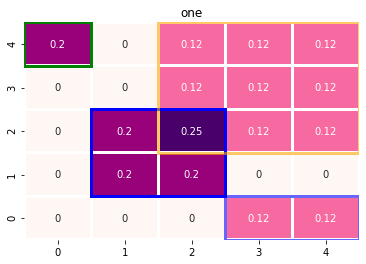

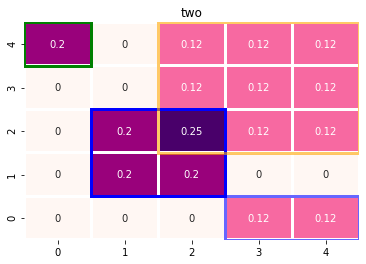

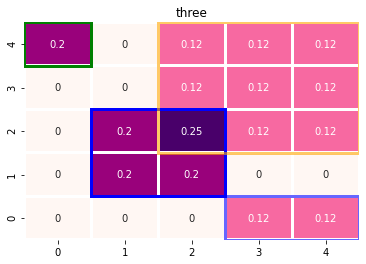

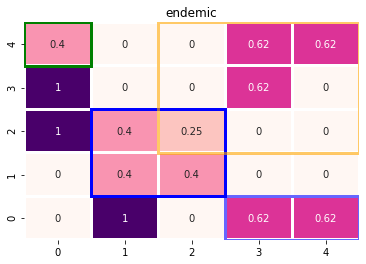

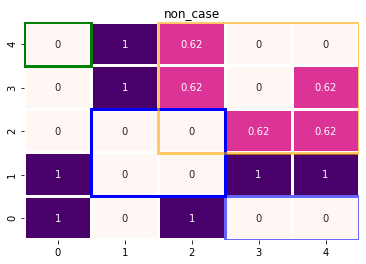

In [25]:
for datalabel in DATA_LABELS:
    plot_heatmap(
        p_hat_di.query("d_i==@datalabel").loc[:, ["p^(d_i)"]].values,
        datalabel,
    )
    plt.show()

In [26]:
eval_df_min = df_di_given_x.merge(
    create_p_hat_di(
        p_hat_di_given_sj_x(),
        p_hat_sj_given_x(
            add_endemic_non_case_signals(signals_without_endemic_non_case, "min")
        ),
    ),
    on=["x1", "x2", "d_i"],
)
eval_df_max = df_di_given_x.merge(
    create_p_hat_di(
        p_hat_di_given_sj_x(),
        p_hat_sj_given_x(
            add_endemic_non_case_signals(signals_without_endemic_non_case, "max")
        ),
    ),
    on=["x1", "x2", "d_i"],
)
eval_df_mean = df_di_given_x.merge(
    create_p_hat_di(
        p_hat_di_given_sj_x(),
        p_hat_sj_given_x(
            add_endemic_non_case_signals(signals_without_endemic_non_case, "mean")
        ),
    ),
    on=["x1", "x2", "d_i"],
)
eval_df_median = df_di_given_x.merge(
    create_p_hat_di(
        p_hat_di_given_sj_x(),
        p_hat_sj_given_x(
            add_endemic_non_case_signals(signals_without_endemic_non_case, "median")
        ),
    ),
    on=["x1", "x2", "d_i"],
)

In [27]:
add_endemic_non_case_signals(signals_without_endemic_non_case, "mean").query("one>0")

,x1,x2,w_A,w_B,w_C,one,two,three,endemic,non_case,w_A_endemic,w_A_non_case,w_B_endemic,w_B_non_case,w_C_endemic,w_C_non_case,w_non_case,w_endemic
6,1.0,1.0,1.0,0.0,0.0,1,0,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.666667
7,1.0,2.0,1.0,0.0,0.0,1,0,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.666667
12,2.0,2.0,1.0,0.5,0.0,1,0,0,0,0,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.500000


In [28]:
def KL(P, Q):
    """Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0."""
    epsilon = 0.00001

    P = P + epsilon
    Q = Q + epsilon

    divergence = np.sum(P * np.log(P / Q))
    return divergence

In [29]:
print("KL")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(KL(eval_df["p(d_i)"].values / 25, eval_df["p^(d_i)"].values / 25))

KL
1.4657710594873727
1.1879392914261868
1.1961577157646184
1.1872399719491133


In [30]:
from scipy.stats import entropy, mannwhitneyu, pearsonr, wilcoxon, bra
from sklearn import metrics

In [31]:
print("KL form scikitlearn")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(entropy(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values + 0.00001))

KL form scikitlearn
1.8546735918556878
1.4484083815323732
1.4566245971432075
1.4476992550726397


$$MI(U,V)=\sum_{i=1}^{|U|} \sum_{j=1}^{|V|} \frac{|U_i\cap V_j|}{N}
    \log\frac{N|U_i \cap V_j|}{|U_i||V_j|}$$

In [31]:
print("brier")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(
        metrics.brier_score_loss(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values)
    )

mutual information


ValueError: Only binary classification is supported. Labels in y_true: [0.         0.33333333 0.5        0.66666667 1.        ].

In [32]:
print("mutual information")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(
        metrics.mutual_info_score(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values)
    )

mutual information
0.29634980972036773
0.3025208486903207
0.305239233279047
0.3025208486903207


In [33]:
print("regression score")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(metrics.r2_score(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values))

regression score
0.3965014577259477
0.45069970845481055
0.4436151603498544
0.4504373177842568


In [34]:
print("RMSE")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(np.sqrt(np.mean((eval_df["p(d_i)"].values - eval_df["p^(d_i)"].values) ** 2)))

RMSE
0.30331501776206204
0.2893748050155331
0.2912349185413346
0.28944391128123215


In [35]:
print("MSE")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(np.mean((eval_df["p(d_i)"].values - eval_df["p^(d_i)"].values) ** 2))

MSE
0.092
0.0837377777777778
0.08481777777777778
0.08377777777777777


In [36]:
print("Correlation")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(pearsonr(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values))

Correlation
(0.6358779630814554, 1.6222647280089715e-15)
(0.6755581314500057, 5.5350859638944124e-18)
(0.6736278112039635, 7.446922491779509e-18)
(0.6779063983989227, 3.846395311135755e-18)


In [37]:
print("Signed-Wilcoxon")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(
        wilcoxon(
            eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values, alternative="two-sided"
        )
    )

Signed-Wilcoxon
WilcoxonResult(statistic=887.5, pvalue=0.8375532487088458)
WilcoxonResult(statistic=923.0, pvalue=0.4292977279173873)
WilcoxonResult(statistic=911.5, pvalue=0.3854536425103928)
WilcoxonResult(statistic=921.5, pvalue=0.4235032323049215)


In [38]:
print("U-test")
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(
        mannwhitneyu(
            eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values, alternative="two-sided"
        )
    )

U-test
MannwhitneyuResult(statistic=6132.5, pvalue=0.0006548121605249147)
MannwhitneyuResult(statistic=5881.0, pvalue=0.00011438066880481344)
MannwhitneyuResult(statistic=5871.0, pvalue=0.0001053546870482734)
MannwhitneyuResult(statistic=5872.0, pvalue=0.00010622047397102864)


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier

X, y = make_multilabel_classification(random_state=0)
inner_clf = LogisticRegression(solver="liblinear", random_state=0)
clf = MultiOutputClassifier(inner_clf).fit(X, y)
y_score = np.transpose([y_pred[:, 1] for y_pred in clf.predict_proba(X)])
roc_auc_score(y, y_score, average=None)

array([0.82664884, 0.86034414, 0.94181818, 0.8502652 , 0.94809095])

### Confusion Matrix

In [40]:
eval_df_mean.loc[:, "true"] = np.where(
    eval_df_mean.loc[:, "p(d_i)"] >= len(MUST_HAVE_LABELS), 1, 0
)
eval_df_mean.loc[:, "pred"] = np.where(
    eval_df_mean.loc[:, "p^(d_i)"] >= 1 / len(DATA_LABELS), 1, 0
)
pivot_eval = eval_df_mean.pivot(
    index=["x1", "x2"], columns="d_i", values=["true", "pred"]
)

In [41]:
list(product(eval_df_mean.d_i.unique(), eval_df_mean.d_i.unique()))

[('one', 'one'),
 ('one', 'two'),
 ('one', 'three'),
 ('one', 'endemic'),
 ('one', 'non_case'),
 ('two', 'one'),
 ('two', 'two'),
 ('two', 'three'),
 ('two', 'endemic'),
 ('two', 'non_case'),
 ('three', 'one'),
 ('three', 'two'),
 ('three', 'three'),
 ('three', 'endemic'),
 ('three', 'non_case'),
 ('endemic', 'one'),
 ('endemic', 'two'),
 ('endemic', 'three'),
 ('endemic', 'endemic'),
 ('endemic', 'non_case'),
 ('non_case', 'one'),
 ('non_case', 'two'),
 ('non_case', 'three'),
 ('non_case', 'endemic'),
 ('non_case', 'non_case')]

In [42]:
pivot_eval_r = eval_df_mean.pivot(
    index=["x1", "x2"], columns="d_i", values=["p(d_i)", "p^(d_i)"]
)

In [43]:
rel_cm = (
    pivot_eval_r.loc[:, "p(d_i)"]
    .reset_index()
    .melt(id_vars=["x1", "x2"], value_name="p(d_i)")
    .merge(pivot_eval_r.loc[:, "p^(d_i)"].reset_index(), on=["x1", "x2"], how="left")
    .assign(
        endemic=lambda x: x["p(d_i)"] * x["endemic"],
        non_case=lambda x: x["p(d_i)"] * x["non_case"],
        one=lambda x: x["p(d_i)"] * x["one"],
        two=lambda x: x["p(d_i)"] * x["two"],
        three=lambda x: x["p(d_i)"] * x["three"],
    )
    .groupby("d_i")
    .agg(dict(zip(["endemic", "non_case", "one", "three", "two"], ["sum"] * 5)))
)

In [44]:
rel_cm

,endemic,non_case,one,three,two
d_i,,,,,
endemic,3.483333,0.000,0.616667,0.616667,0.616667
non_case,0.000000,10.125,0.625000,0.625000,0.625000
one,1.050000,0.000,0.650000,0.650000,0.650000
three,0.729167,0.000,0.145833,0.145833,0.145833
two,2.712500,0.000,0.262500,0.262500,0.262500


In [45]:
rel_cm.loc[
    [c for c in rel_cm.columns if c != "one"], [c for c in rel_cm.columns if c != "one"]
].sum().sum()

20.349999999999998

In [46]:
pd.DataFrame(
    {
        "true_pred": [
            rel_cm.loc["one", "one"],
            rel_cm.loc[[c for c in rel_cm.columns if c != "one"], "one"].sum(),
        ],
        "false_pred": [
            rel_cm.loc["one", [c for c in rel_cm.columns if c != "one"]].sum(),
            rel_cm.loc[
                [c for c in rel_cm.columns if c != "one"],
                [c for c in rel_cm.columns if c != "one"],
            ]
            .sum()
            .sum(),
        ],
    },
    index=["true_groundtruth", "false_groundtruth"],
)

,true_pred,false_pred
true_groundtruth,0.65,2.35
false_groundtruth,1.65,20.35


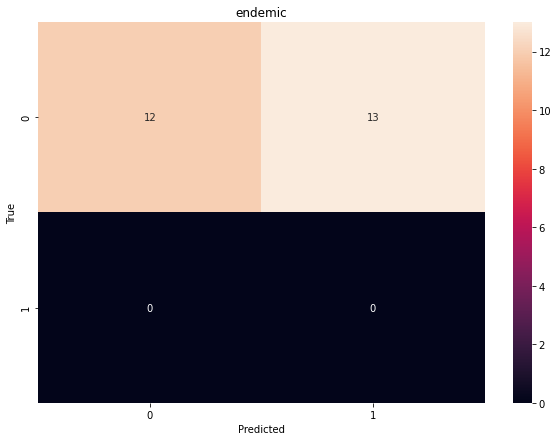

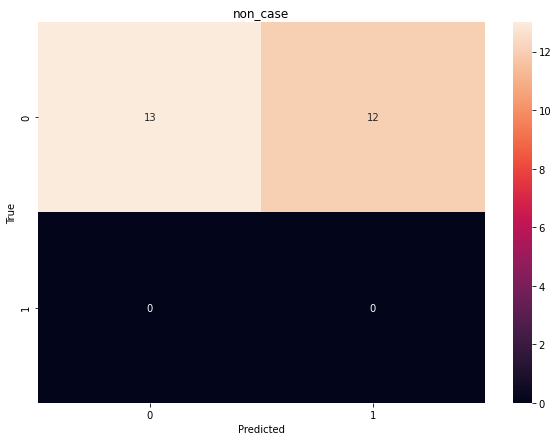

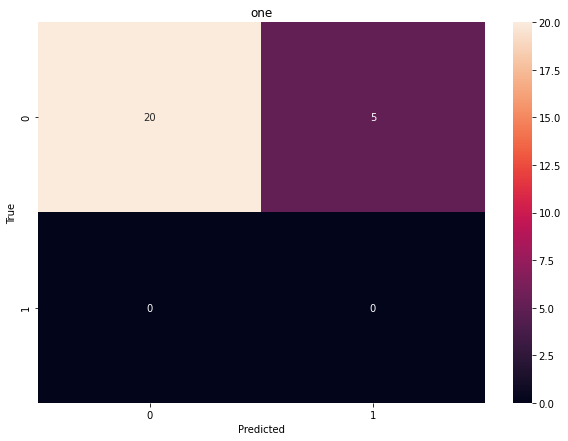

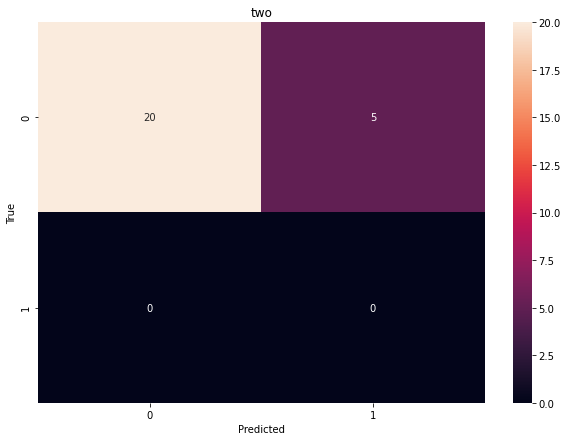

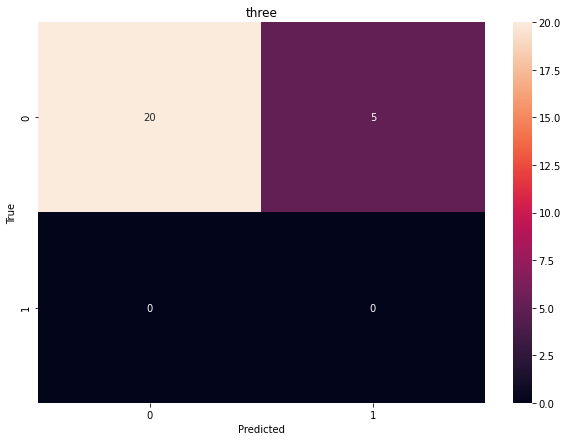

In [47]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix

cm = multilabel_confusion_matrix(
    pivot_eval.loc[:, "true"].values, pivot_eval.loc[:, "pred"].values
)
for i, label in enumerate(["endemic", "non_case", "one", "two", "three"]):
    df_cm = pd.DataFrame(cm[i], index=["0", "1"], columns=["0", "1"])
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True).set(title=label, ylabel="True", xlabel="Predicted")

In [48]:
for label in ["endemic", "non_case", "one", "two", "three"]:
    print(label)
    print(
        classification_report(
            pivot_eval.loc[:, ("true", label)].values,
            pivot_eval.loc[:, ("pred", label)].values,
        )
    )
    print("******\n\n\n")

endemic
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        25
           1       0.00      0.00      0.00         0

    accuracy                           0.48        25
   macro avg       0.50      0.24      0.32        25
weighted avg       1.00      0.48      0.65        25

******



non_case
              precision    recall  f1-score   support

           0       1.00      0.52      0.68        25
           1       0.00      0.00      0.00         0

    accuracy                           0.52        25
   macro avg       0.50      0.26      0.34        25
weighted avg       1.00      0.52      0.68        25

******



one
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        25
           1       0.00      0.00      0.00         0

    accuracy                           0.80        25
   macro avg       0.50      0.40      0.44        25
weighted avg       1.00      0.80

C:\Users\AbboodA\AppData\Local\Continuum\miniconda3\envs\scoring\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
for label in ["endemic", "non_case", "one", "two", "three"]:
    eval_df_mean.loc[:, "true"] = eval_df_mean.loc[:, "p(d_i)"]
    eval_df_mean.loc[:, "pred_true"] = np.where(
        eval_df_mean.loc[:, "p^(d_i)"] > 0.5, 1, 0
    )
    pivot_eval = eval_df_mean.pivot(
        index=["x1", "x2"], columns="d_i", values=["true", "pred_true"]
    )
    print(label)
    print(
        eval_df_mean.query(f"d_i=='{label}'")
        .assign(false=lambda x: 1 - x["true"])
        .assign(pred_false=lambda x: 1 - x["pred_true"])
        .drop(columns="pred")
        .assign(
            true_positive=lambda x: x["true"] * x["pred_true"],
            true_negative=lambda x: x["false"] * x["pred_false"],
            false_positive=lambda x: x["false"] * x["pred_true"],
            false_negative=lambda x: x["true"] * x["pred_false"],
        )
        .sum()
        .iloc[-4:]
    )
    print("\n")

endemic
true_positive     4.33333
true_negative          16
false_positive    3.66667
false_negative          1
dtype: object


non_case
true_positive     12
true_negative     13
false_positive     0
false_negative     0
dtype: object


one
true_positive      0
true_negative     22
false_positive     0
false_negative     3
dtype: object


two
true_positive        0
true_negative     21.5
false_positive       0
false_negative     3.5
dtype: object


three
true_positive           0
true_negative     23.8333
false_positive          0
false_negative    1.16667
dtype: object




### How to score when algo is a classifier
- We look into data distribution and set a cut-off based on data distribution. We assume that the non-outbreak numbers are highest around 0. This peak will flatten when we move away from 0. There we set a cut-off when the next peak is about to start (probably a outbreak cluster)
- Discretize p(d_i) into bins and predict vector of bins
- p(d_i) \element of {0,1} -> confusion matrix

R = [0,1]

B = {0,1}
- p \element R AND p^ \element R -> like the lower, when threshold for p^ is set to e.g., 0.5
- p \element R AND p^ \element B ->
- p \element B AND p^ \element R -> easy/known/ROC/AUC
- p \element B AND p^ \element B -> easy

### References
- KL, Entropy, MI (Wie macht es inhatlich Sinn die Entropie zu berechnen, gegeben den verschiedenen Zellen und DataLabels)
    - Referenz: https://arxiv.org/pdf/1802.03446.pdf
    - Referenz: https://www.sciencedirect.com/science/article/pii/S107731420700077X (pixel-based classifications)
    - Referenz: https://iopscience.iop.org/article/10.1088/1755-1315/47/1/012042/pdf (pixel-based classifications)
    - Likelihood methoden anschauen
    - https://en.wikipedia.org/wiki/Kernel_embedding_of_distributions

## TODO:    
- Classifikations-Fall (Wie komme ich von einem kontinuierlichen Wert der Daten auf einen binären
    - simplere Beispiele (ein perfektes, ein komplett missklassifiziertes, ein 50/50 Beispiel)
## Backlog:
- z-score-based binning (https://core.ac.uk/download/pdf/82692314.pdf)
    - in general quantiles
- attribute cell to data with highest probability